In [84]:
import deepchem as dc
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from deepchem.models import GraphConvModel
from deepchem.models.callbacks import ValidationCallback

# Load the dataset
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

# Define the model
model = GraphConvModel(n_tasks=len(tasks), mode='classification', dropout=0.2)

# Define early stopping parameters
patience = 10
interval = 1
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")

def fit_with_early_stopping(model, train_dataset, valid_dataset, nb_epoch, patience):
    best_score = None
    best_epoch = None
    best_model = None
    list_scores = []
    wait = 0

    for epoch in range(nb_epoch):
        print(f"Epoch {epoch+1}/{nb_epoch}")
        model.fit(train_dataset, nb_epoch=1)

        if (epoch + 1) % interval == 0:
            valid_scores = model.evaluate(valid_dataset, [metric], transformers)
            valid_score = valid_scores[metric.name]
            print(valid_scores)

            training_scores = model.evaluate(train_dataset, [metric], transformers)
            training_score = training_scores[metric.name]

            list_scores.append((epoch + 1, valid_score, training_score))

            if best_score is None or valid_score > best_score:
                best_score = valid_score
                best_epoch = epoch + 1
                best_model = model.save_checkpoint(model_dir="model.ckpt")
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print("Early stopping triggered at epoch:", epoch + 1)
                    break
    
    print(f"Best model found at epoch {best_epoch} with {metric.name} score: {best_score}")
    return list_scores

# Train the model with early stopping
my_model = fit_with_early_stopping(model, train_dataset, valid_dataset, nb_epoch=100, patience=patience)


Epoch 1/100
{'mean-roc_auc_score': 0.6339173648723969}
Epoch 2/100
{'mean-roc_auc_score': 0.6684368244151174}
Epoch 3/100
{'mean-roc_auc_score': 0.6781974019782654}
Epoch 4/100
{'mean-roc_auc_score': 0.6858954729130584}
Epoch 5/100
{'mean-roc_auc_score': 0.7041717530114884}
Epoch 6/100
{'mean-roc_auc_score': 0.7028305135629447}
Epoch 7/100
{'mean-roc_auc_score': 0.7122233228084834}
Epoch 8/100
{'mean-roc_auc_score': 0.7138502627209652}
Epoch 9/100
{'mean-roc_auc_score': 0.7255239379206838}
Epoch 10/100
{'mean-roc_auc_score': 0.7243827490326195}
Epoch 11/100
{'mean-roc_auc_score': 0.7375064700620083}
Epoch 12/100
{'mean-roc_auc_score': 0.7266404167107833}
Epoch 13/100
{'mean-roc_auc_score': 0.7380151087433636}
Epoch 14/100
{'mean-roc_auc_score': 0.7365103557752842}
Epoch 15/100
{'mean-roc_auc_score': 0.7399298528266657}
Epoch 16/100
{'mean-roc_auc_score': 0.7434115957901906}
Epoch 17/100
{'mean-roc_auc_score': 0.738193719238985}
Epoch 18/100
{'mean-roc_auc_score': 0.7437632736274741}
Ep

<function matplotlib.pyplot.show(close=None, block=None)>

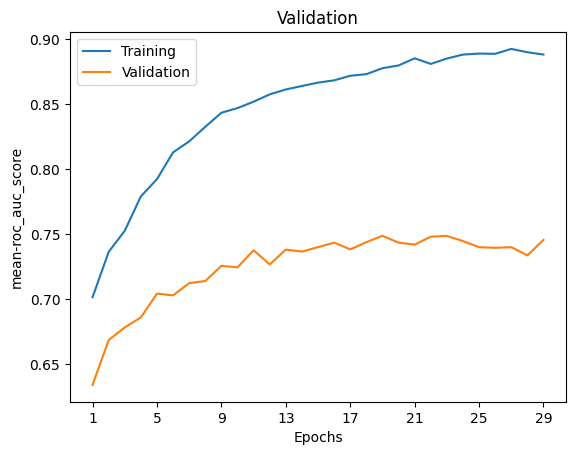

In [85]:
epochs = [x[0] for x in my_model]
train_scores = [x[2] for x in my_model]
valid_scores = [x[1] for x in my_model]

plt.plot(epochs, train_scores, label='Training')
plt.plot(epochs, valid_scores, label='Validation')
plt.gca().set(xlabel='Epochs', ylabel=metric.name, title='Validation')
plt.xticks(range(min(epochs), max(epochs) + 1, 4))
plt.legend()
plt.show

In [86]:
load_model = GraphConvModel(n_tasks=len(tasks), mode='classification', dropout=0.2)

# Disables warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# restores model
status = load_model.restore(model_dir="model.ckpt")

# Reenables warnings
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

In [87]:
eval = load_model.evaluate(valid_dataset, [metric], transformers)
print(eval)

preds = load_model.predict(test_dataset)
preds

{'mean-roc_auc_score': 0.7486604329881317}


array([[[0.32653472, 0.67346525],
        [0.60785735, 0.39214268],
        [0.8022818 , 0.1977182 ],
        ...,
        [0.5246048 , 0.4753952 ],
        [0.82655495, 0.17344499],
        [0.9103405 , 0.08965954]],

       [[0.13282786, 0.8671721 ],
        [0.7459522 , 0.2540479 ],
        [0.0478976 , 0.9521024 ],
        ...,
        [0.19619623, 0.8038038 ],
        [0.05904549, 0.94095457],
        [0.00953241, 0.9904676 ]],

       [[0.8798121 , 0.12018787],
        [0.9848305 , 0.0151695 ],
        [0.42549506, 0.574505  ],
        ...,
        [0.36878026, 0.63121974],
        [0.11375894, 0.886241  ],
        [0.7240015 , 0.2759985 ]],

       ...,

       [[0.49954423, 0.50045574],
        [0.60660666, 0.3933934 ],
        [0.11433925, 0.8856607 ],
        ...,
        [0.35598576, 0.6440143 ],
        [0.27951244, 0.7204876 ],
        [0.60045975, 0.39954022]],

       [[0.71350986, 0.2864901 ],
        [0.8053003 , 0.19469965],
        [0.9786804 , 0.02131962],
        .